# Exercises Week 4 in 02506

This weeks exercises are concerned with feature based registration and SIFT from OpenCV.
<p align="center"> 
  <img src="images/ct_lab_high_res.PNG" width="300" title="Artificially generated blobs">
</p>

## Imports

In [1]:
import numpy as np
from skimage.io import imread, imshow, imsave
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from skimage import color
import cv2

## 4.1 Exercise on feature-based registration

### 1. Generate a random 2D point set P.

In [7]:
def getPoints(arr):
    nonz = np.nonzero(arr)
    x = nonz[1]
    y = H-1-nonz[0]
    return x,y

class Points:
    
    def __init__(self,x,y):
        assert(np.size(x) == np.size(y))
        self.x = x
        self.y = y
        self.ite = 0
        self.len = np.size(x)

    def next(self):
        tmp = self.ite
        self.ite = self.ite+1
        if (self.ite >= self.len):
            self.reset()
        return self.x[tmp],self.y[tmp]

    def reset(self):
        self.ite = 0

    def append(self,x,y):
        self.x.append(x)
        self.y.append(y)
        self.len = self.len + 1

    def length(self):
        return self.len

H = 256
W = 408
np.random.seed(199)
Ptmp = np.zeros([H,W]).astype(float)
tmp = np.random.rand(80,60)
tmp[tmp<0.97]=0
tmp[tmp>=0.97]=255
Ptmp[68:148,164:224] = tmp

x,y = getPoints(Ptmp)
P = Points(x,y)


### 2. Define variables for translation t, rotation R, and scale s, and decide on their values.

### 3. Transform P using these parameters to obtain the point set Q.

In [8]:
def RotateScaleTranslate(pts,theta,t=[[0],[0]],s=1.0):
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    cx = 0#np.mean(pts.x)
    cy = 0#np.mean(pts.y)
    new_pts = Points([],[])
    for i in range(pts.length()):
        x,y = pts.next()
        xybar = s*(R@[[x-cx],[y-cy]])+t
        xbar = cx+xybar[0][0]
        ybar = cy+xybar[1][0]
        new_pts.append(xbar,ybar)
    return new_pts, R
s = 2.2
t = [[50],[20]]
Q,R = RotateScaleTranslate(P,0.3,t=t,s=s)
print(f"R is {R} ")

R is [[ 0.95533649 -0.29552021]
 [ 0.29552021  0.95533649]] 


### 4. Plot these point sets using two different colors.

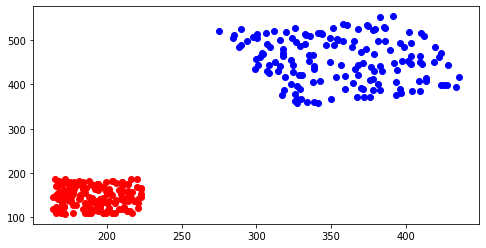

In [9]:
fig, (ax1) = plt.subplots(1, 1,figsize=(8,4))
ax1.scatter(P.x, P.y, color='Red')
ax1.scatter(Q.x, Q.y, color='Blue')
#ax1.set_ylim([0,H])
#ax1.set_xlim([0,W])

### 5. Implement a function that computes the parameters t', rotation R', and scale s' from P and Q. Make sure that you get the exact same values.

In [10]:
def getScale(Pr,Qr):
    Pmux = np.mean(Pr.x)
    Pmuy = np.mean(Pr.y)
    Qmux = np.mean(Qr.x)
    Qmuy = np.mean(Qr.y)
    sumP = np.sum([np.sqrt((x-Pmux)**2 + (y-Pmuy)**2) for x,y in zip(Pr.x,Pr.y)])
    sumQ = np.sum([np.sqrt((x-Qmux)**2 + (y-Qmuy)**2) for x,y in zip(Qr.x,Qr.y)])
    return sumQ/sumP

def getRot(Qr,Pr): # notice that input should be P,Q, not Q,P
    Pmu = np.array([[np.mean(Pr.x)],[np.mean(Pr.y)]])
    tmp1 = np.array( [Pr.x,Pr.y])-Pmu
    Qmu = np.array([[np.mean(Q.x)],[np.mean(Qr.y)]])
    tmp2 = np.array([Qr.x,Qr.y])-Qmu
    C = sum([np.array([[q[0]*p[0],q[0]*p[1]],[q[1]*p[0],q[1]*p[1]]]) for q,p in zip(tmp1.T,tmp2.T)])
    U,_,Vt = np.linalg.svd(C,full_matrices=True)
    Rbar = np.matmul(U,Vt)
    Rbar = np.matmul(Rbar,[[1.0,0.0],[0.0,np.linalg.det(Rbar)]])
    return Rbar

def getTranslation(Pr,Qr,R,s):
    Pmu = np.array([[np.mean(Pr.x)],[np.mean(Pr.y)]])
    Qmu = np.array([[np.mean(Qr.x)],[np.mean(Qr.y)]])
    return Qmu-s*R@Pmu

sbar = getScale(P,Q)
Rbar = getRot(P,Q)
tbar = getTranslation(P,Q,Rbar,sbar)
print(f"sbar={sbar},s={s}")
print(f"Rbar={Rbar}")
print(f"R={R}")
print(f"tbar={tbar}")
print(f"t={t}")

sbar=2.2,s=2.2
Rbar=[[ 0.95533649 -0.29552021]
 [ 0.29552021  0.95533649]]
R=[[ 0.95533649 -0.29552021]
 [ 0.29552021  0.95533649]]
tbar=[[50.]
 [20.]]
t=[[50], [20]]


### 6. Add some noise to Q and recompute the parameters and test how much noise you can add and still get reasonably good parameter estimates.

s=2.2030321477466313
t=[[51.74071418]
 [17.86904767]]
R=[[ 0.95403869 -0.29968345]
 [ 0.29968345  0.95403869]]


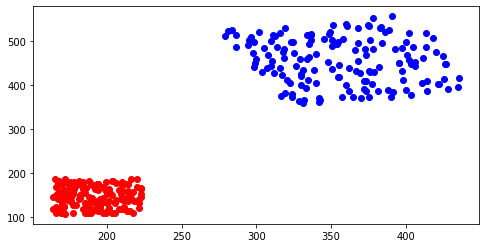

In [12]:
sigma = 4
Qnoisy = Points([],[])
for i in range(Q.length()):
    xt,yt = Q.next()
    xt = xt + np.random.normal(0,4)
    yt = yt + np.random.normal(0,4)
    Qnoisy.append(xt,yt)

fig, (ax1) = plt.subplots(1, 1,figsize=(8,4))
ax1.scatter(P.x, P.y, color='Red')
ax1.scatter(Qnoisy.x, Qnoisy.y, color='Blue')

sbar = getScale(P,Qnoisy)
Rbar = getRot(P,Qnoisy)
tbar = getTranslation(P,Qnoisy,Rbar,sbar)

print(f"s={sbar}")
print(f"t={tbar}")
print(f"R={Rbar}")

## 4.1.2 Compute and match SIFT
### 1. Create a transformed image by rotating, scaling, and cropping an image. We call the original image1 and the transformed image2.

[[  0.9781476    0.20791169 -37.21185831]
 [ -0.20791169   0.9781476   45.95281802]]


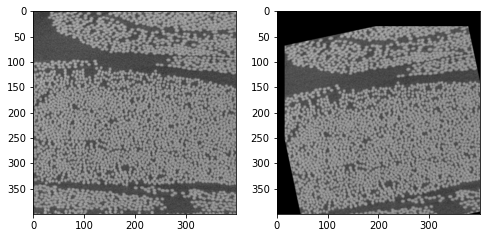

In [35]:
img1 = cv2.imread("./images/CT_lab_low_res.png")
height, width = img1.shape[:2]
center = (width/2, height/2)
rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=12, scale=1)
print(rotate_matrix)
img2 = cv2.warpAffine(src=img1, M=rotate_matrix, dsize=(width, height))
translation_matrix = np.array([[1, 0, 15], [0, 1, 30]], dtype=np.float32)
img2 = cv2.warpAffine(src=img2, M=translation_matrix, dsize=(width, height))
cv2.imshow('Original image', img1)
cv2.imshow('Rotated image', img2)

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8,4))
ax1.imshow(img1)
ax2.imshow(img2)

### 2. Compute SIFT features in the two images.

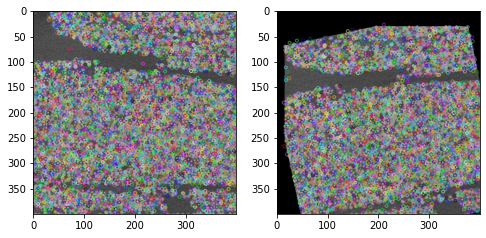

In [36]:
def np2cv(P):
    return ((P - np.min(P)) * 255 / np.max(P)).astype(np.uint8)

def npSift(P):
    data = np2cv(P)
    gray = data.astype(np.uint8)
    sift = cv2.SIFT_create()
    kp = sift.detect(gray,None)
    img=cv2.drawKeypoints(gray,kp,P)
    return img

def sift(img1):
    gray = img1.astype(np.uint8)
    sift1 = cv2.SIFT_create()
    kp = sift1.detect(gray,None)
    img=cv2.drawKeypoints(gray,kp,img1)
    return img

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8,4))
ax1.imshow(sift(img1))
ax2.imshow(sift(img2))

imsave('./images/test_img.png',img1)
imsave('./images/test_img_transformed.png',img2)

### 3. Match the SIFT features. You can use the functionality for matching SIFT from vlFeat for MATLAB and OpenCV for Python.
### 4. Display the match to see if the matching criterion is correct.

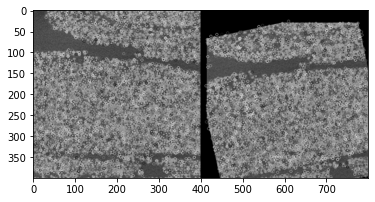

(<matplotlib.image.AxesImage at 0x7f18790ea9d0>, None)

In [37]:
img1 = cv2.imread('./images/test_img.png',cv2.IMREAD_GRAYSCALE)          # queryImage
img2 = cv2.imread('./images/test_img_transformed.png',cv2.IMREAD_GRAYSCALE) # trainImage

# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance/(n.distance+1e-10) < 0.25:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

### 5. Extract the coordinates of the matching keypoints.

In [38]:
pts1 = Points([],[])
pts2 = Points([],[])
for m,n in matches:
    if m.distance/(n.distance+1e-10) < 0.8:
        pts1.append(kp1[m.queryIdx].pt[0],kp1[m.queryIdx].pt[1])
        pts2.append(kp2[m.trainIdx].pt[0],kp2[m.trainIdx].pt[1])

print(pts1.x)
print(pts2.x)


[51.710784912109375, 81.24071502685547, 89.48543548583984, 106.78043365478516, 140.6107635498047, 144.45455932617188, 153.71421813964844, 197.8004608154297, 199.62310791015625, 201.28489685058594, 202.7332305908203, 223.52317810058594, 223.7408905029297, 239.3411865234375, 249.90200805664062, 266.0282897949219, 281.85443115234375, 283.4867248535156, 302.5823974609375, 339.446044921875, 368.98486328125]
[349.2137145996094, 327.3538818359375, 75.25870513916016, 349.33050537109375, 43.689842224121094, 150.08712768554688, 382.3252868652344, 183.584228515625, 185.95640563964844, 188.9332733154297, 188.2728729248047, 170.0829620361328, 268.15277099609375, 295.4913330078125, 275.97918701171875, 306.60589599609375, 157.0133819580078, 118.19145202636719, 228.40846252441406, 293.4981689453125, 383.148681640625]


### 6. Use the function for computing the rotation, translation, and scale from before to transform the set of key points found in image1 to the set of keypoints found in image2.

In [40]:
sbar = getScale(pts1,pts2)
Rbar = getRot(pts1,pts2)
tbar = getTranslation(pts1,pts2,Rbar,sbar)
print(f"s={sbar}")
print(f"t={tbar}")
print(f"R={Rbar}")

s=0.9421309210170365
t=[[15.89839263]
 [98.19393541]]
R=[[ 0.98782348  0.1555788 ]
 [-0.1555788   0.98782348]]


### 7. Display image2 and plot the key points found in image2 and the transformed key points from image1.

Estimated homography : 
 [[ 1.23519915e+00 -6.56430715e-02 -2.48019665e+01]
 [ 9.86941582e-02  1.34750200e+00 -8.54295695e+01]
 [-6.41745003e-04  1.18583118e-03  1.00000000e+00]]


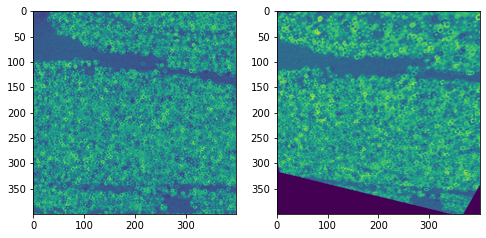

In [42]:
pts1 = []
pts2 = []
num_matches = 0
for m,n in matches:
    if m.distance/(n.distance+1e-10) < 0.80:
        pts2.append([kp1[m.queryIdx].pt[0],kp1[m.queryIdx].pt[1]])
        pts1.append([kp2[m.trainIdx].pt[0],kp2[m.trainIdx].pt[1]])
        num_matches = num_matches+1
pts1 = np.reshape(pts1,[num_matches,2,1])
pts2 = np.reshape(pts2,[num_matches,2,1])

h, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC)

height, width = img2.shape
im1Reg = cv2.warpPerspective(img2, h, (width, height))

print("Estimated homography : \n",  h)

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8,4))
ax1.imshow(img1)
ax2.imshow(im1Reg)

### Quiz

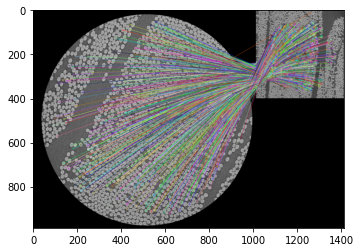

(<matplotlib.image.AxesImage at 0x7f18544447c0>, None)

In [54]:
img1 = cv2.imread('./images/quiz_image_1.png',cv2.IMREAD_GRAYSCALE)          # queryImage
img2 = cv2.imread('./images/quiz_image_2.png',cv2.IMREAD_GRAYSCALE) # trainImage

# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance/(n.distance+1e-10) < 0.60:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

In [55]:
pts1 = Points([],[])
pts2 = Points([],[])
for m,n in matches:
    if m.distance/(n.distance+1e-10) < 0.6:
        pts1.append(kp1[m.queryIdx].pt[0],kp1[m.queryIdx].pt[1])
        pts2.append(kp2[m.trainIdx].pt[0],kp2[m.trainIdx].pt[1])

sbar = getScale(pts1,pts2)
Rbar = getRot(pts1,pts2)
tbar = getTranslation(pts1,pts2,Rbar,sbar)
print(f"s={sbar}")
print(f"t={tbar}")
print(f"R={Rbar}")

s=0.3690402851730338
t=[[448.15718086]
 [301.0368171 ]]
R=[[-0.92124955 -0.38897206]
 [ 0.38897206 -0.92124955]]


In [56]:
print(f"1/s={1/sbar},s={sbar}")
import math
print(math.degrees(math.acos(Rbar[0,0])))
print(np.sqrt(tbar[0]**2+tbar[1]**2))

1/s=2.7097312683116015,s=0.3690402851730338
157.10944700360616
[539.87778618]
